In [38]:
from moseq2_detectron_extract.quality import find_outliers_h5
from moseq2_detectron_extract.proc.keypoints import (
    find_nan_keypoints, find_outliers_jumping, load_keypoint_data_from_h5)
import h5py
from moseq2_detectron_extract.io.annot import default_keypoint_names
from moseq2_detectron_extract.proc.proc import clamp_angles
import seaborn as sns
import numpy as np

In [29]:
h5_path = r"D:\moseq-extract-testing\floating_blobs\session_20210304155906\proc\results_00.h5"
h5 = h5py.File(h5_path, 'r')
keypoint_names = [kp for kp in default_keypoint_names if kp != 'TailTip']
kpts = load_keypoint_data_from_h5(h5, keypoint_names, coord_system='rotated')

centroids = np.column_stack((h5['/scalars/centroid_x_px'], h5['/scalars/centroid_y_px']))

print(keypoint_names)
print(kpts.shape)
print(centroids.shape)

['Nose', 'Left Ear', 'Right Ear', 'Neck', 'Left Hip', 'Right Hip', 'TailBase']
(35999, 7, 3)
(35999, 2)


In [3]:
# construct an array with the expected signs
# positive values mean the row node expects to be to the EAST of the column node
# negative values mean the row node expects to be to the WEST of the column node
# zeros indicate we have no particular expectation of the east-west relation, i.e. they should be approximatly the same position on the EAST-WEST axis

# 	Nose	LeftEar	RightEar	Neck	LeftHip	RightHip	TailBase
# Nose	0	1	1	1	1	1	1
# LeftEar	-1	0	0	1	1	1	1
# RightEar	-1	0	0	1	1	1	1
# Neck	-1	-1	-1	0	1	1	1
# LeftHip	-1	-1	-1	-1	0	0	1
# RightHip	-1	-1	-1	-1	0	0	1
# TailBase	-1	-1	-1	-1	-1	-1	0

expected_alignment = np.array([
    [ 0,  1,  1,  1,  1,  1,  1],
    [-1,  0,  0,  1,  1,  1,  1],
    [-1,  0,  0,  1,  1,  1,  1],
    [-1, -1, -1,  0,  1,  1,  1],
    [-1, -1, -1, -1,  0,  0,  1],
    [-1, -1, -1, -1,  0,  0,  1],
    [-1, -1, -1, -1, -1, -1,  0]
])
expected_alignment

array([[ 0,  1,  1,  1,  1,  1,  1],
       [-1,  0,  0,  1,  1,  1,  1],
       [-1,  0,  0,  1,  1,  1,  1],
       [-1, -1, -1,  0,  1,  1,  1],
       [-1, -1, -1, -1,  0,  0,  1],
       [-1, -1, -1, -1,  0,  0,  1],
       [-1, -1, -1, -1, -1, -1,  0]])

In [16]:
def calc_keypoint_keypoint_distance(keypoints: np.ndarray, metric: str = 'x') -> np.ndarray:
    '''Calculate a distance matrix for each keypoint against others

    Parameters:
    kaypoints (np.ndarray): array of keypoint data, of shape (nkeypoints, [at least 2: x, y]) or (nframes, nkeypoints, [at least 2: x, y])
    metric (str): one of {euclidean, x, y}, type of distance to calculate
    '''
    if len(keypoints.shape) == 3:
        dist = np.ndarray((keypoints.shape[0], keypoints.shape[1], keypoints.shape[1]), dtype=float)
    else:
        dist = np.ndarray((keypoints.shape[0], keypoints.shape[0]), dtype=float)

    for i in range(dist.shape[-1]):
        for j in range(dist.shape[-1]):
            if metric == 'euclidean':
                dist[:, i, j] = np.sqrt(((keypoints[:, i, 0] - keypoints[:, j, 0])**2) + ((keypoints[:, i, 1] - keypoints[:, j, 1])**2))

            elif metric == 'x':
                dist[..., i, j] = keypoints[..., i, 0] - keypoints[..., j, 0]

            elif metric == 'y':
                dist[..., i, j] = keypoints[..., i, 1] - keypoints[..., j, 1]

    return dist


def compute_keypoint_alignment_scores(keypoints, expected_alignment):
    # calculate keypoint-keypoint distances, and take only the signs
    distances = calc_keypoint_keypoint_distance(keypoints)
    distance_signs = np.sign(distances)

    # mask to zeros keypoint pairs for which we do not have strong expectations
    masked_distance_signs = np.where(expected_alignment == 0, 0, distance_signs)

    # compute number of keypoint pairs which agree with our expectations, subtracting those which we do not have strong expectations for
    axis = (1, 2) if len(keypoints.shape) == 3 else None
    num_expectations_met = np.count_nonzero(masked_distance_signs == expected_alignment, axis=axis) - np.count_nonzero(expected_alignment == 0)

    # generate scores by normalizing to the number of keypoint pairs for which we have a strong expectation
    scores = num_expectations_met / np.count_nonzero(expected_alignment)

    # finally return scores
    return scores

In [17]:
# single frame of keypoints, of shape (nkeypoints, 3)
compute_flips(kpts[0], expected_alignment)

1.0

In [20]:
# many frames of keypoints, of shape (nframes, nkeypoints, 3)
compute_flips(kpts, expected_alignment)

array([1., 1., 1., ..., 1., 1., 1.])

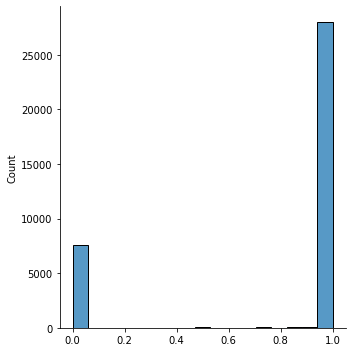

In [21]:
sns.displot(compute_flips(kpts, expected_alignment))

In [22]:
np.where(compute_flips(kpts, expected_alignment) == 0)

(array([ 9211, 22295, 22296, ..., 33553, 35917, 35948], dtype=int64),)

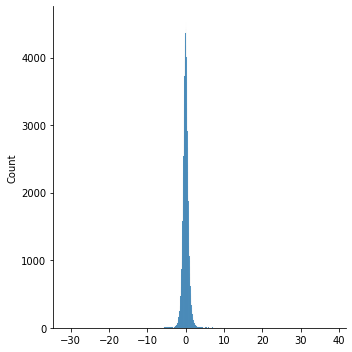

In [26]:
sns.displot(np.diff(kpts[:, :, :2], axis=0)[:,:,0].ravel())

In [34]:
good = 22289
bad = 22291
kpts[good, :, :2] - kpts[bad, :, :2]

array([[ 12.64243877,   5.90862942],
       [  5.86471754,  -6.26074056],
       [ -4.20991623,   3.07722521],
       [ -1.78661299,  -4.86296326],
       [ -6.90989065, -12.31468678],
       [-13.59203756,  -6.10597515],
       [-15.36178064, -12.24201846]])

In [43]:
o1 = kpts[good, :, :2]# - centroids[good, :]
o2 = kpts[bad, :, :2]# - centroids[bad, :]


a1 = np.arctan2(o1[..., 1], o1[..., 0])
a2 = np.arctan2(o2[..., 1], o2[..., 0])
a = a1 - a2

#cosine_angle = np.dot(o1[i], o2[i]) / (np.linalg.norm(o1[i]) * np.linalg.norm(o2[i]))
#angle = np.arccos(cosine_angle)

angles = clamp_angles(np.degrees(a))

angles

array([87.76844491, 83.47120835, 62.7225871 , 84.42756707, 77.33059172,
       92.8114129 , 86.95275328])

In [40]:
np.mean(angles)

82.21208076117678

In [41]:
np.median(angles)

84.42756707430726

In [59]:
angles = np.arctan2(kpts[..., 1], kpts[..., 0])
angles = clamp_angles(np.rad2deg(angles))
angles = np.diff(angles, axis=0, prepend=angles[0,None,...])
angles.shape

(35999, 7)

In [57]:
angles.mean(axis=1)

array([ 0.        , -0.01589338,  0.04177816, ..., -0.07437256,
        0.08042789, -0.02527371])

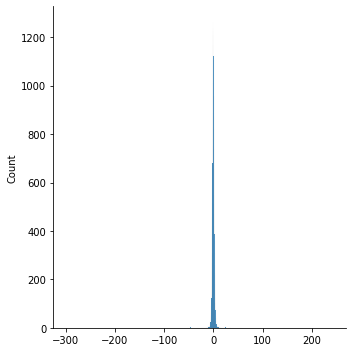

In [66]:
sns.displot(np.median(angles, axis=1))

In [68]:
np.where((np.median(angles, axis=1) < -200))

(array([29613], dtype=int64),)

In [79]:
def estimate_keypoint_rotation(keypoints):
    '''Estimate the relative rotation between subsequent sets of keypoints

    Parameters:
    keypoints (np.ndarray): keypoints, of shape (nframes, nkeypoints, at least 2)
    '''
    angles = np.arctan2(keypoints[..., 1], keypoints[..., 0])
    angles = clamp_angles(np.rad2deg(angles))
    angles = np.diff(angles, axis=0, prepend=angles[0,None,...])
    print(angles.shape)
    angles = angles % 360
    to_min = angles > 180
    angles[to_min] = -(360 - angles[to_min])
    print(angles.shape)
    return np.median(angles, axis=1)

(35999, 7)
(35999, 7)


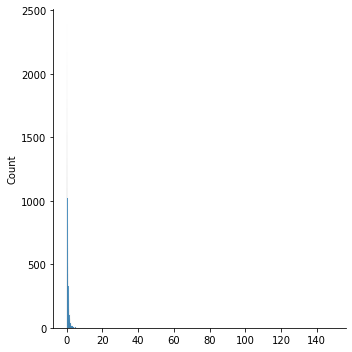

In [80]:
sns.displot(estimate_keypoint_rotation(kpts))

In [81]:
np.where(estimate_keypoint_rotation(kpts) > 45)

(35999, 7)
(35999, 7)


(array([ 9208,  9212, 11631, 11632, 13041, 14175, 22202, 24990, 25330,
        28732, 28853, 29537, 29608, 29614, 29733, 29739, 29752, 29761,
        29762, 29889, 29914, 30026, 30043, 30131, 30217, 30269, 30275,
        30469, 30788, 31035, 31201, 31207, 33212, 33315, 33343, 33351,
        33352, 33546, 35930, 35952], dtype=int64),)